Felipe Bastos Vargas - 2023008881
João Gabriel Miguêz da Silva - 2023008890

# Regressão de Custo de Seguro Médico (Estados Unidos)

Nese arquivo sobre regressão, foi escolhido um dataset sobre o custo de operações médicas de planos de saúde nos Estados Unidos. As análises serão feitas de acordo com caracteristicas dos pacientes, e com o preço cobrado de cada um.

## Definições e Pré Processamento
Importando bibliotecas e limpando os dados, removendo qualquer linha que esteja com dados nulos. 
Modelos matemáticos exigem entradas numéricas. Por isso, variáveis categóricas como o gênero e o tabagismo foram transformadas em binários (0 e 1), e a region foi transformada via One-Hot Encoding.
Nesta parte também definimos duas funções que vão facilitar mais para frente. Uma que plota os gráficos com base no valor previsto no modelo e o valor real, e outra que calcula os valores de avaliação da qualidade do funcionamento de cada modelo.

In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

In [149]:
# Definindo função para gerar os gráficos

def plot_results(real, predicted, model_name):
    plt.figure(figsize=(14, 5))

    # Gráfico 1: Dispersão (Real vs Previsto)
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=real, y=predicted, alpha=0.6)
    plt.plot([real.min(), real.max()], [real.min(), real.max()], '--r', linewidth=2) # Linha ideal
    plt.xlabel('Valor Real (Charges)')
    plt.ylabel('Valor Previsto')
    plt.title(f'{model_name}: Real vs Previsto')

# Função para calcular as medidas de avaliação

def print_evaluate(real, predicted):
    mae = metrics.mean_absolute_error(real, predicted)
    mse = metrics.mean_squared_error(real, predicted)
    rmse = np.sqrt(mse)
    r2_square = metrics.r2_score(real, predicted)
    print('MAE:', mae)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)

In [150]:
medical = pd.read_csv("insurance.csv")
medical.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Verificar linhas faltantes
Testamos para ver se alguma linha possui algum dado faltante, neste caso não temos nenhum dado ausente

In [151]:
medical.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [152]:
medical[medical.isna().any(axis=1)]

,age,sex,bmi,children,smoker,region,charges


#### Ajuste de valores de texto
Transformados as medidas de texto para valores numéricos, para conseguirmos usar no dataset. Por exemplo, mudando o status de fumante de 'yes' e 'no' para 1 ou 0

In [153]:
medical = medical.replace({'yes':1,'no':0})
medical = medical.replace({'male':1,'female':0})
medical.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


#### Ajuste de valores fora de escala
O valor da região, embora sendo texto, não pode apenas ser convertido em valores de 0 a 3, logo, precisamos separar em 4 valores binários diferentes, e é isso que o próximo bloco faz

In [154]:
medical = pd.get_dummies(medical, columns=['region'], dtype=int)
medical.head()

,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,0,1
1,18,1,33.770,1,0,1725.55230,0,0,1,0
2,28,1,33.000,3,0,4449.46200,0,0,1,0
3,33,1,22.705,0,0,21984.47061,0,1,0,0
4,32,1,28.880,0,0,3866.85520,0,1,0,0


### Gráfico para análise do pré-processamento

Os gráficos a seguir foi gerado para tentarmos perceber se existe alguma relação entre os dados do dataset. Para issom temos o imx no eixo X, e o custo no eixo Y, e uma variação na cor dos pontos dependendo se o paciente é fumante ou não para o primeiro gráfico, e por idade no segundo.

Analisando o primeiro gráfico, podemos perceber que a grande maioria dos fumantes estão na metade superior do gráfico, ou seja, ser fumante tem um impacto significativo no custo. Podemos perceber também que para os fumantes, existe um salto grande perto do imc de 30, tendo praticamente um degrau neste ponto, enquanto para não fumantes, esse padrão não é perceptível.

Para o gráfico com variação de cor por idade, vemos que os mais idosos tem um custo maior também, explicando alguns dos outliers do primeiro gráfico. Porém vale notar que essa variação de custo por idade está contida dentro dos subgrupos de fumantes ou não fumantes.

Com isso temos uma boa base para sabermos como o conjunto de dado tem seu funcionamento geral, e podemos em seguida focar em como cada modelo interpreta esses dados.

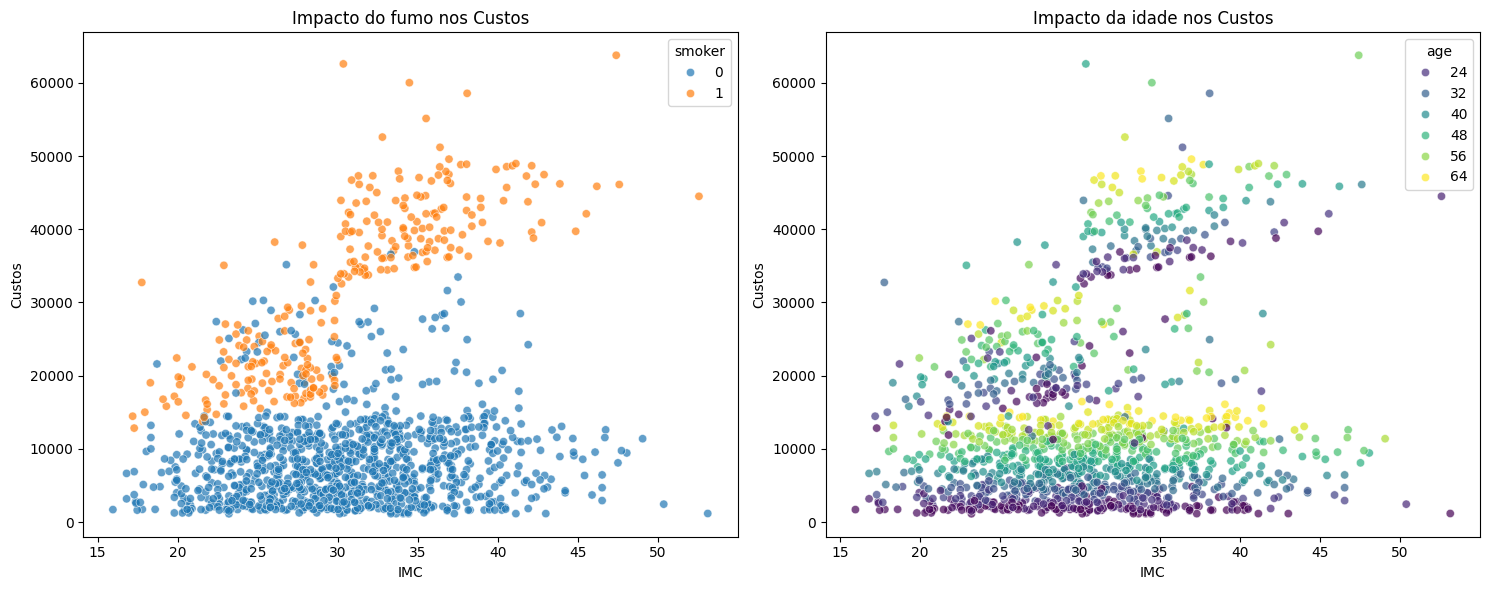

In [155]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1) 
sns.scatterplot(data=medical, x='bmi', y='charges', hue='smoker', alpha=0.7)
plt.title('Impacto do fumo nos Custos')
plt.xlabel('IMC')
plt.ylabel('Custos')

plt.subplot(1, 2, 2) 
sns.scatterplot(data=medical, x='bmi', y='charges', hue='age', palette='viridis', alpha=0.7)
plt.title('Impacto da idade nos Custos')
plt.xlabel('IMC')
plt.ylabel('Custos')

plt.tight_layout() # Ajusta os espaçamentos para não encavalar
plt.show()

### Desenvolvimento

Agora vamos aplicar os últimos preparos, separando uma parte do banco de dados para treino (70%) e uma outra para teste (30%). Aqui também escalamos alguns dados que podem ficar muito fora da curva, já que o valor de fumante que varia de 0 à 1 seria muito sobreposto por valores como a idade, podendo afetar o desempenho do programa.

In [156]:
from sklearn.model_selection import train_test_split

x_val = medical.drop(['charges'], axis=1).values
y_val = medical['charges']

x_train, x_test, y_train, y_test = train_test_split(x_val, y_val, test_size=0.3, random_state=42)

In [157]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Aplicação dos modelos

Todos os métodos de aplicação foram gerados com gráficos para análise mais visual do fitting realizado.
Na análise dos valores de avaliação, também são comparados os valores de treino com os de teste, para verificar se não está ocorrendo overfitting.

### Regressão Linear
É o modelo mais simples deste documento, servindo como uma linha de base de o que esperar dos outros métodos de regressão. Funciona melhor em conjuntos de dados simples e que possuem relações mais diretas. No nosso caso não é um modelo totalmente ruim, já que existe sim uma certa linearidade nos dados que estão sendo observados. Obteve um R² de aproximadamente 0.743. Poderia ser melhor, mas para um uso simples pode ser uma boa aplicação

Regressão Linear:
MAE: 4145.450555627599
RMSE: 5812.100272258872
R2 Square 0.769611805436901
---------------------
MAE: 4251.255798614485
RMSE: 6142.519818737067
R2 Square 0.7423980090600258


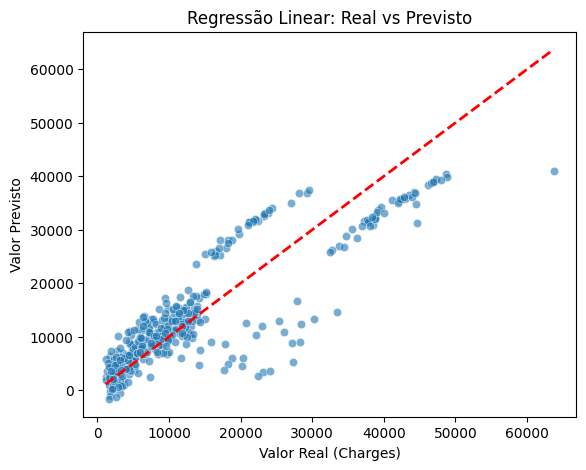

In [158]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(x_train_scaled, y_train) # Pode usar sem scale, mas com scale não faz mal
pred_lin = lin_reg.predict(x_test_scaled)
pred_lin_train = lin_reg.predict(x_train_scaled)

print("Regressão Linear:")
print_evaluate(y_test, pred_lin)
print("---------------------")
print_evaluate(y_train, pred_lin_train)

plot_results(y_test, pred_lin, "Regressão Linear")

### Árvore de decisão

Este modelo divide os valores em subgrupos, podendo perceber relações mais complexas, separando por exemplo grupos de fumantes com mais de 50 anos em um grupo. Uma desvantegem é que é bem propícia ao overfitting, e como podemos perceber neste caso, o R² de teste foi de apenas 0.72, sendo o pior de todos os modelos utilizados, e o R quadrado do treino estava como 1, acertando todas as previsões, mas num cenário de testes, decaiu muito.

Árvore de Decisão:
MAE: 2869.0015002462687
RMSE: 6382.979232175056
R2 Square 0.7221304948440255
---------------------
MAE: 0.0
RMSE: 0.0
R2 Square 1.0


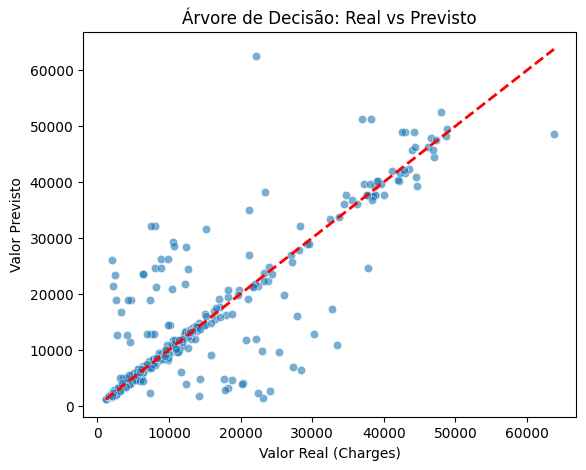

In [159]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(x_train, y_train) # Árvores não precisam necessariamente de dados escalados
pred_tree = tree_reg.predict(x_test)
pred_tree_train = tree_reg.predict(x_train)

print("Árvore de Decisão:")
print_evaluate(y_test, pred_tree)
print("---------------------")
print_evaluate(y_train, pred_tree_train)

plot_results(y_test, pred_tree, "Árvore de Decisão")

### SVR

O SVR busca encontrar uma margem de tolerância ao redor da previsão onde o erro é aceitável. Utilizamos o kernel RBF (Radial Basis Function), que projeta os dados em dimensões superiores para encontrar padrões curvos e complexos.

Teve um resultado altamente agradavel se comparado com a rede neural. Podemos notar uma diferença em seu gráfiuco, onde os dados de custo baixo são muito mais previsíveis que os valores para custo mais alto, onde conforme aumenta o custo, o erro também aumenta.

SVM (SVR):
MAE: 1771.3769424460309
RMSE: 4654.68488484433
R2 Square 0.8522339734224502
---------------------
MAE: 1866.0354096279634
RMSE: 4918.330218519754
R2 Square 0.8348451048477156


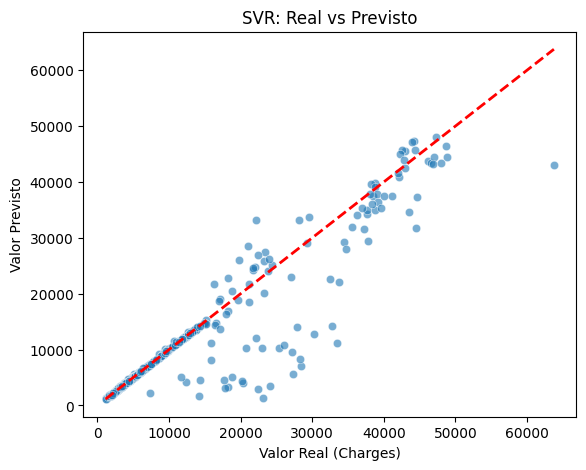

In [160]:
from sklearn.svm import SVR

svr_reg = SVR(kernel='rbf', C=10000, epsilon=0.1) # C alto ajuda neste dataset
svr_reg.fit(x_train_scaled, y_train)
pred_svr = svr_reg.predict(x_test_scaled)
pred_svr_train = svr_reg.predict(x_train_scaled)

print("SVM (SVR):")
print_evaluate(y_test, pred_svr)
print("---------------------")
print_evaluate(y_train, pred_svr_train)

plot_results(y_test, pred_svr, "SVR")

### MLP

O mlp é uma rede neural artificial, que usa de neurônios matemáticos para processar os dados, podendo achar padrões extremamente complexos, porém, faz isso de uma forma muito mais "escondida", também demorando muito mais tempo para que o treinamento alcance um resultado suficientemente bom. 

A rede neural obteve o melhor desempenho de todos os modelos, conseguindo agrupar muito bem os dados e prever muito bem, sem ter muitos erros grotescos

MLP Regressor:
MAE: 2755.8377643492627
RMSE: 4732.582733636947
R2 Square 0.847246751562564
---------------------
MAE: 2447.606758498885
RMSE: 4190.708307929128
R2 Square 0.8800967517523984


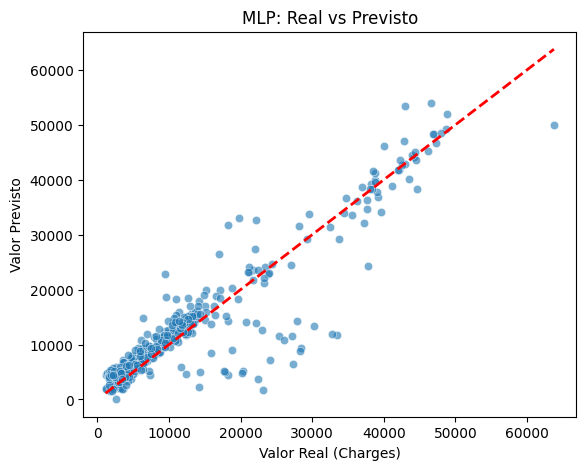

In [161]:
from sklearn.neural_network import MLPRegressor

# max_iter=5000 garante que ela tenha tempo de aprender
mlp_reg = MLPRegressor(hidden_layer_sizes=(100,50), max_iter=5000, random_state=42)
mlp_reg.fit(x_train_scaled, y_train)
pred_mlp = mlp_reg.predict(x_test_scaled)
pred_mlp_train = mlp_reg.predict(x_train_scaled)

print("MLP Regressor:")
print_evaluate(y_test, pred_mlp)
print("---------------------")
print_evaluate(y_train, pred_mlp_train)

plot_results(y_test, pred_mlp, "MLP")

### Conclusão e Análise de Resultados

A análise dos resultados demonstra que os modelos testados obtiveram desempenhos variados, refletindo suas diferentes capacidades de lidar com a complexidade dos dados de custos médicos. O MLP (Rede Neural) e o SVR se destacaram como os melhores modelos, ambos alcançando um coeficiente de determinação R² superior a 0.83. Esse resultado valida a hipótese de que a relação entre as variáveis (especialmente idade, IMC e fumo) e os custos médicos possui componentes não-lineares fortes, que modelos mais simples têm dificuldade em capturar.

A Árvore de Decisão apresentou um desempenho insatisfatório, estando abaixo do requisito mínimo do projeto, além de mostrar nos gráficos uma tendência a segmentar as previsões em patamares discretos. Já a Regressão Linear, embora tenha atingido um R² próximo de 0.75, serviu principalmente como linha de base, evidenciando que uma abordagem puramente linear é insuficiente para modelar com precisão os saltos de custo causados por fatores de risco combinados.

Portanto, para a previsão de custos médicos neste cenário, o uso de modelos robustos como SVR ou Redes Neurais é altamente recomendado, pois eles oferecem o melhor equilíbrio entre precisão e capacidade de generalização.